In [1]:
import random
import numpy as np
import scipy.io
from pyDOE import lhs

import torch
from torch import nn, optim, autograd

import torch.nn.init as init
from torch.nn import functional as F

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable

from utils_training_EC import *

#Paper reproduction
random_seed_set = 1234
set_random_seed(random_seed_set)

In [2]:
N_train = 1000
N_bound = 200

# x,t
la = np.array([1, 1])
lb = np.array([-1, 0])

traindata = lb + (la - lb) * lhs(2, N_train)

x_inside = traindata[:, 0:1]
t_inside = traindata[:, 1:2]

x_inside = numpy_to_tensor(x_inside,
                           var_name="x_inside",
                           value_range_dim=True,
                           to_torch=True,
                           to_cuda=True,
                           requires_grad=True)

t_inside = numpy_to_tensor(t_inside,
                           var_name="t_inside",
                           value_range_dim=True,
                           to_torch=True,
                           to_cuda=True,
                           requires_grad=True)

x_inside: Column 0: range from -0.9996169610992423 to 0.9999084330058925
t_inside: Column 0: range from 0.0006221087710398319 to 0.9998795647581709


In [3]:
def exact_func(data_input):

    x_value = data_input[:, 0:1]
    t_value = data_input[:, 1:2]

    return np.exp(-t_value) * np.sin(np.pi * x_value)

In [4]:
x_exact = np.linspace(-1,1,200).reshape(-1,1)

t_exact = np.linspace(0,1,200).reshape(-1,1)

print('t_exact:', t_exact.shape)
print('x_exact:', x_exact.shape)

t_exact: (200, 1)
x_exact: (200, 1)


In [5]:
X_exact, T_exact = np.meshgrid(x_exact, t_exact)
print('X_exact:', X_exact.shape)
print('T_exact:', T_exact.shape)

X_exact_flatten = X_exact.flatten()[:, None]
T_exact_flatten = T_exact.flatten()[:, None]
data_star = np.hstack((X_exact_flatten, T_exact_flatten))

u_star = exact_func(data_star)
Exact_u = u_star.reshape(X_exact.shape)

X_exact: (200, 200)
T_exact: (200, 200)


In [6]:
data_star.shape

(40000, 2)

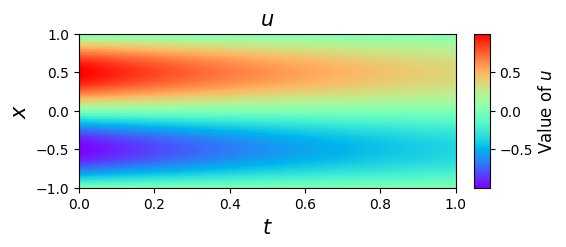

In [7]:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 2))

cmap = plt.get_cmap('jet')
heatmap1 = ax1.imshow(Exact_u.T,
                      interpolation='nearest',
                      cmap='rainbow',
                      extent=[0, 1, -1, 1],
                      origin='lower',
                      aspect='auto')

ax1.set_title(r'$u$', fontsize=15)
ax1.set_xlabel(r'$t$', fontsize=15)
ax1.set_ylabel(r'$x$', fontsize=15)

# Add a color bar
cbar = fig.colorbar(heatmap1, ax=ax1, fraction=0.15, pad=0.04, aspect=10)
cbar.set_label(r'Value of $u$', fontsize=12)

plt.show()

In [8]:
random_seed = 1234
np.random.seed(random_seed)
observe_number = 10

observe_data = lb + (la - lb) * lhs(2, observe_number)
observe_clear_u = exact_func(observe_data)

noise_nu = 0.02
noise_std = 0.05
noise_u = np.random.normal(loc=noise_nu, scale=noise_std, size=observe_clear_u.shape)
observe_u = observe_clear_u + noise_u

observe_data = numpy_to_tensor(observe_data,
                               var_name="observe_data",
                               value_range_dim=True,
                               to_torch=True,
                               to_cuda=True,
                               requires_grad=True)

observe_clear_u = numpy_to_tensor(observe_clear_u,
                                  var_name="observe_u",
                                  value_range_dim=True,
                                  to_torch=True,
                                  to_cuda=True,
                                  requires_grad=True)

observe_u = numpy_to_tensor(observe_u,
                            var_name="observe_u",
                            value_range_dim=True,
                            to_torch=True,
                            to_cuda=True,
                            requires_grad=True)

noise_u = numpy_to_tensor(noise_u,
                            var_name="noise_u",
                            value_range_dim=True,
                            to_torch=True,
                            to_cuda=True,
                            requires_grad=False)

observe_data_x_inside = observe_data[:, 0:1]
observe_data_t_inside = observe_data[:, 1:2]

observe_data: Column 0: range from -0.9616961099242215 to 0.9545653243224748
observe_data: Column 1: range from 0.06221087710398319 to 0.9882641190636117
observe_u: Column 0: range from -0.4622391171270676 to 0.6941402599252228
observe_u: Column 0: range from -0.39752830832666186 to 0.821010580522772
noise_u: Column 0: range from 0.00010798859000043029 to 0.13954802577315165


In [9]:
np.random.seed(5678)
N_test_number = 10000

test_data = lb + (la - lb) * lhs(2, N_test_number)
test_u = exact_func(test_data)

test_data = numpy_to_tensor(test_data,
                            var_name="test_data",
                            value_range_dim=True,
                            to_torch=True,
                            to_cuda=True,
                            requires_grad=True)

test_u = numpy_to_tensor(test_u,
                         var_name="test_u",
                         value_range_dim=True,
                         to_torch=True,
                         to_cuda=True,
                         requires_grad=True)

test_data_x_inside = test_data[:, 0:1]
test_data_t_inside = test_data[:, 1:2]

test_data: Column 0: range from -0.9999021346039978 to 0.999818369091213
test_data: Column 1: range from 5.933244265166393e-06 to 0.9999791490405054
test_u: Column 0: range from -0.9962151573581175 to 0.9967165533751065


In [10]:
print('The number of observational data J:', len(observe_u))

The number of observational data J: 10


In [11]:
def output_transform(x_input, y_input):

    x_in = x_input[:, 0:1]
    t_in = x_input[:, 1:2]

    return (1 - x_in) * (1 + x_in) * (1 - torch.exp(-t_in)) * y_input + torch.sin(np.pi * x_in)

In [12]:
def get_loss_f_1(x_grad, t_grad, PINNs, C, return_sequence='not'):

    E_inside = PINNs(torch.cat((x_grad, t_grad), dim=1))
    E_inside = output_transform(torch.cat((x_grad, t_grad), dim=1), E_inside)

    u_xx = compute_higher_order_derivatives(E_inside, [x_grad, x_grad])
    u_t = compute_higher_order_derivatives(E_inside, [t_grad])

    loss_term = u_t - C * u_xx + torch.exp(-t_grad) * (
        torch.sin(torch.tensor(np.pi) * x_grad) - torch.tensor(np.pi) *
        torch.tensor(np.pi) * torch.sin(torch.tensor(np.pi) * x_grad))

    if return_sequence == 'yes':
        return torch.square(loss_term)
    else:
        return torch.mean(torch.square(loss_term))

In [13]:
Theta_list = np.zeros_like(observe_u.cpu().detach().numpy())
Theta_list_1 = numpy_to_tensor(Theta_list,
                             var_name="Theta_list",
                             value_range_dim=True,
                             to_torch=True,
                             to_cuda=True,
                             requires_grad=True)

Theta_list_id = id(Theta_list_1)

optimizer_error = optim.Adam([Theta_list_1],
                             lr=0.0001,
                             betas=(0.9, 0.999),
                             eps=1e-08,
                             weight_decay=0,
                             amsgrad=False)

Theta_list: Column 0: range from 0.0 to 0.0


In [14]:
x_inside_all = torch.cat((x_inside,observe_data[:,0:1]),dim=0)
t_inside_all = torch.cat((t_inside,observe_data[:,1:2]),dim=0)

In [15]:
data_inputs = {
    'x_inside_all': x_inside_all,
    't_inside_all': t_inside_all,
    'x_inside': x_inside,
    't_inside': t_inside,
    'observe_data': observe_data,
    'noise_u': noise_u,
    'observe_u': observe_u,
    'observe_clear_u': observe_clear_u,
    'observe_data_x_inside': observe_data_x_inside,
    'observe_data_t_inside': observe_data_t_inside,
    'test_data': test_data,
    'test_u': test_u,
    'test_data_x_inside': test_data_x_inside,
    'test_data_t_inside': test_data_t_inside,
    'C1': None,
}

In [16]:
#Paper reproduction
random_seed_set = 1234
set_random_seed(random_seed_set)

In [17]:
net_settings_for_PINNs_1 = NetSetting(input_dims=2,
                                     hidden_neurons_list=[20] * 4,
                                     output_dims=1,
                                     hidden_activation='tanh',
                                     output_activation=None,
                                     initializer_method='xavier')

PINNs_1 = get_mlp_pinn(net_settings_for_PINNs_1)
PINNs_1.cuda()

initialize_weights(PINNs_1, net_settings_for_PINNs_1.initializer_method)

optimizer_pinn = optim.Adam(PINNs_1.parameters(),
                        lr=0.001,
                        betas=(0.9, 0.999),
                        eps=1e-08,
                        weight_decay=0,
                        amsgrad=False)

C1 = torch.tensor(2.0, requires_grad=True)
C1_id = id(C1)
optimizer_pinn.add_param_group({'params': [C1], 'lr': 0.001})

In [18]:
nIter1 = 20000
it = 0
training_recorder_1 = training_recorder()

if_timing_point = False
loss_noise_elimination = torch.mean(torch.square(Theta_list_1 - noise_u))

while it < nIter1:
    #########loss f#########
    loss_f = get_loss_f_1(x_inside_all, t_inside_all, PINNs_1, C1)
    
    #########loss T noisy observation#########
    E_observation = PINNs_1(observe_data)
    E_observation = output_transform(observe_data, E_observation)
    loss_error_correction = torch.mean(torch.square(E_observation + Theta_list_1 - data_inputs['observe_u']))
    
    #########loss PI#########
    loss_all = loss_f + 10 * loss_error_correction 

    data_inputs['C1'] = C1
    test_loss  = training_calculator(PINNs_1, get_loss_f_1, Theta_list_1,
                                     training_recorder_1, data_inputs, output_transform)
    
    if it % 1000 == 0:
        print(f"Iterations: {it}, train_loss: {loss_all.item():.8f}, test_loss: {test_loss:.6f}, noise_elimination_loss: {loss_noise_elimination:.6f}")
        change_C_learning_rate(optimizer_pinn, C1_id, learning_rate = None)
        print('Estimated parameter:',C1)
        change_EC_factors_learning_rate(optimizer_error, learning_rate = None)
        print('----------------------------------------------------------------')
    
    optimizer_pinn.zero_grad()
    loss_all.backward()
    optimizer_pinn.step()

    if if_timing_point == False:
        if it > 3200:
            (PINNs, C, it, optimizer_pinn_input,
             if_timing_point) = training_recall(it, PINNs_1, C1,
                                                optimizer_pinn, training_recorder_1,
                                                if_timing_point, threshold = 0, window_wide = 300)
                
    else:
        Theta_list, loss_noise_elimination = train_for_error_correction(PINNs_1, C1, optimizer_error, 
                                                                        Theta_list_1, data_inputs,
                                                                        output_transform)
    
    it = it + 1
    
print(f"Final result: train_loss: {loss_all.item():.8f}, test_loss: {test_loss:.6f}, noise_elimination_loss: {loss_noise_elimination:.6f}")
print('Estimated parameter:',C1)

output_dir = '../experimental_data/Diffusion/EC_N2/'
training_recorder_1.save(output_dir)

Iterations: 0, train_loss: 104.84895325, test_loss: 0.653587, noise_elimination_loss: 0.004004
Current C1 learning rate: 0.001
Estimated parameter: tensor(2., requires_grad=True)
Current EC_factors learning rate: 0.0001
----------------------------------------------------------------
Iterations: 1000, train_loss: 0.80078530, test_loss: 0.381480, noise_elimination_loss: 0.004004
Current C1 learning rate: 0.001
Estimated parameter: tensor(1.7201, requires_grad=True)
Current EC_factors learning rate: 0.0001
----------------------------------------------------------------
Iterations: 2000, train_loss: 0.36878043, test_loss: 0.347249, noise_elimination_loss: 0.004004
Current C1 learning rate: 0.001
Estimated parameter: tensor(1.5933, requires_grad=True)
Current EC_factors learning rate: 0.0001
----------------------------------------------------------------
Iterations: 3000, train_loss: 0.25043887, test_loss: 0.302036, noise_elimination_loss: 0.004004
Current C1 learning rate: 0.001
Estimat